In [21]:
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [22]:
plt.style.use('ggplot')
plt.style.use({'figure.dpi': 150})

In [23]:
def read_xyz_frame(f_in):
    """Read one frame from an open XYZ file.

    Returns `None` if there are no more frames.
    """

    line = f_in.readline()
    if line == '':
        return None
    N = int(line)
    comment = f_in.readline()[:-1]
    names = []
    data = []
    for i in range(N):
        items = f_in.readline().split()
        names.append(items[0])
        data.append([float(item) for item in items[1:]])

    return comment, names, np.array(data)

In [24]:
def read_xyz(fn_in: str):
    """Iterate all frames from an XYZ file."""

    with open(fn_in) as f_in:
        while True:
            frame = read_xyz_frame(f_in)
            if not frame:
                break
            yield frame

In [25]:
def read_xyz_data(fn_in: str):
    """Read an XYZ file, return array with all data."""
    frames = read_xyz(fn_in)
    data = np.array([frame[2] for frame in frames])
    return data

## Load data

In [26]:
fn_energy = 'energy.txt'
fn_positions = 'positions.xyz'
fn_velocities = 'velocities.xyz'

In [27]:
data_energy = np.loadtxt(fn_energy)
t = data_energy[:,1]

In [28]:
q = read_xyz_data(fn_positions)
v = read_xyz_data(fn_velocities)

In [29]:
# check the shape of the data
print(q.shape)

(20001, 10, 3)


## Process and plot

### Scalar quantities

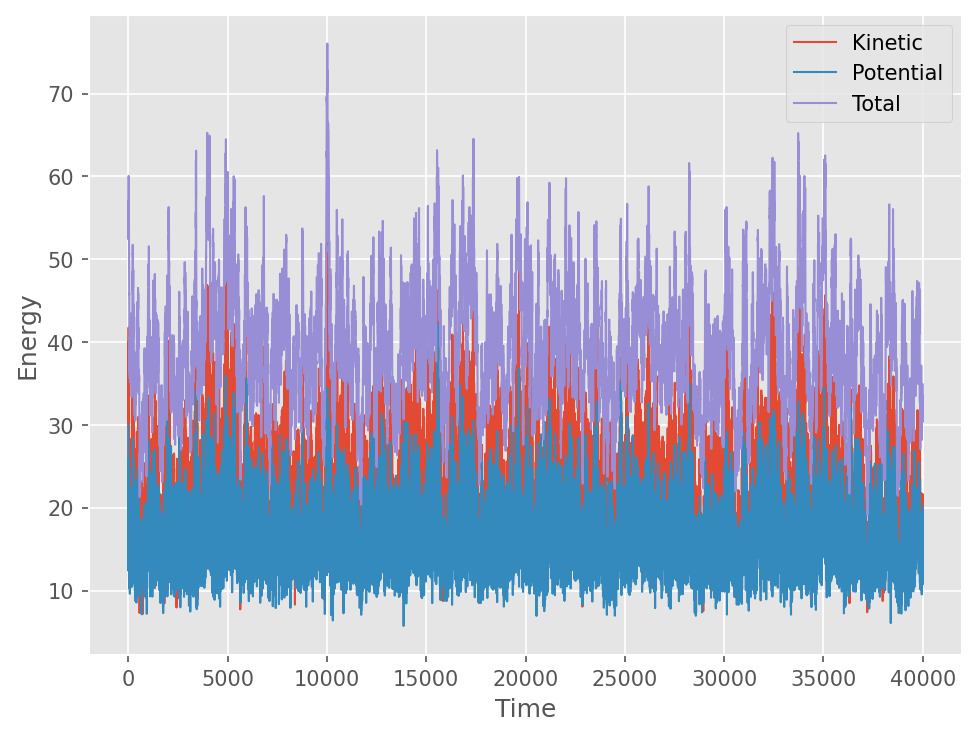

In [30]:
plt.figure(constrained_layout=True)
plt.plot(t, data_energy[:,2], label='Kinetic', lw=1)
plt.plot(t, data_energy[:,3], label='Potential', lw=1)
plt.plot(t, data_energy[:,4], label='Total', lw=1)
plt.xlabel('Time')
plt.ylabel('Energy')
plt.legend();

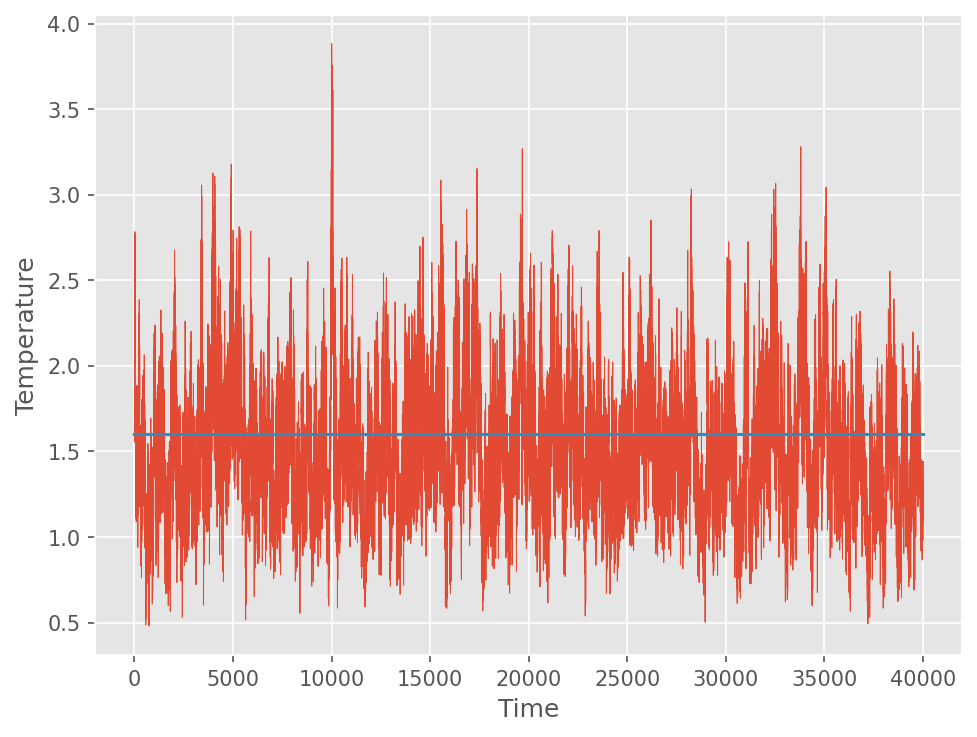

In [31]:
plt.figure(constrained_layout=True)
plt.plot(t, data_energy[:,5], label='Temperature', lw=0.5)
plt.plot([0,2*len(t)], [1.6,1.6])
plt.xlabel('Time')
plt.ylabel('Temperature');

### Trajectory example

In [44]:
# trimmed data for trajectory example plotting
# one particular DOF for a chunk of time
idx_start = 0
idx_end = 100
t_plot = t[idx_start:idx_end]
q_plot = q[idx_start:idx_end, 0, 0]
v_plot = v[idx_start:idx_end, 0, 0]

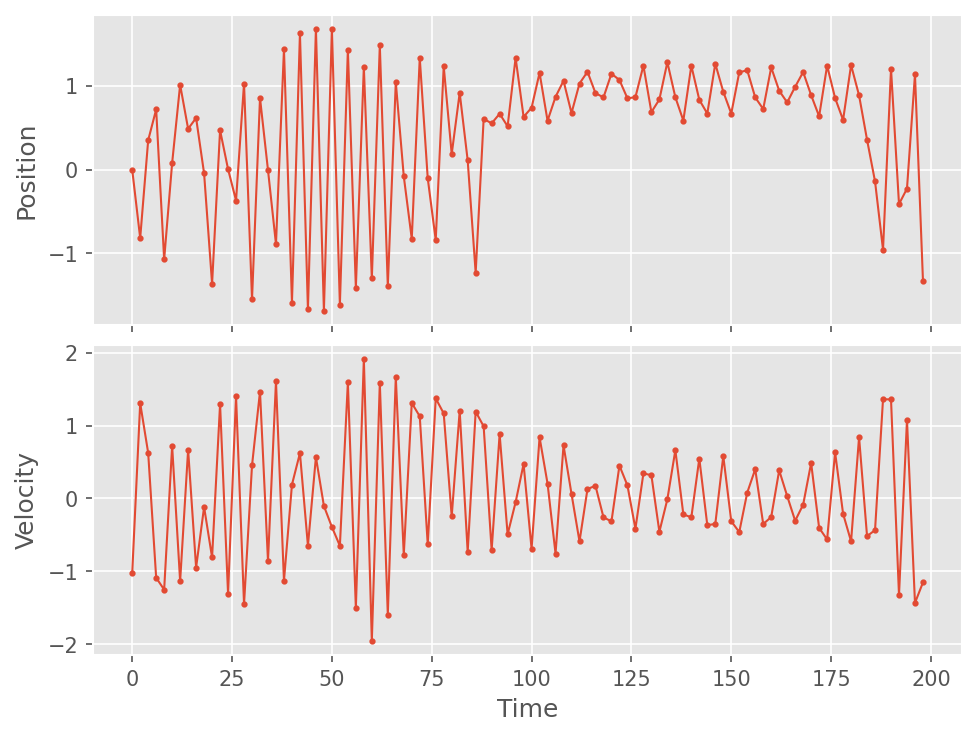

In [45]:
plt.subplots(2, 1, sharex=True, constrained_layout=True)

plt.subplot(2, 1, 1)
plt.plot(t_plot, q_plot, '.-', lw=1.0, ms=4.0)
plt.ylabel('Position')

plt.subplot(2, 1, 2)
plt.plot(t_plot, v_plot, '.-', lw=1.0, ms=4.0)
plt.ylabel('Velocity')

plt.xlabel('Time');

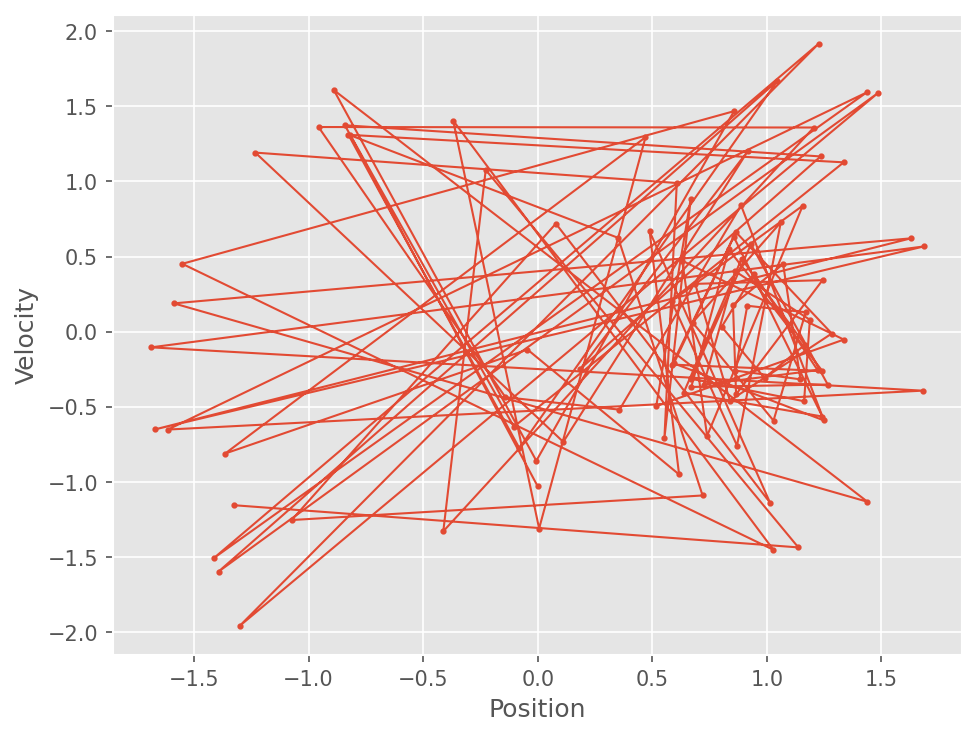

In [46]:
plt.figure(constrained_layout=True)
plt.plot(q_plot, v_plot, '.-', lw=1.0, ms=4.0)
plt.xlabel('Position')
plt.ylabel('Velocity');

### Probability distributions

In [35]:
def interactions_double_well(q, D0=1.0, a=1.0, l=1.0):
    """Evaluate potential energy and its derivatives at configuration `x` for a double well potential."""
    U = (D0 / a**4) * ((q**2 - a**2)**2 + l*q).sum()
    dU_dq = 4 * (D0 / a**4) * (q**2 - a**2) * q + l
    return U, dU_dq

In [36]:
# Here we set the parameters and potential by hand.
# Later, we can save this information from the simulation itself.

k_B = 1.0
T = 1.6
beta = 1.0 / (k_B * T)

m = 1.5

interactions = partial(interactions_double_well, l=0.0)

In [37]:
# histogram the loaded data

# trim off estimated equilibration
idx_trim = 1000
q_trim = q[idx_trim:, :, :]
v_trim = v[idx_trim:, :, :]

# set histogram ranges
range_q = [-2.5, 2.5]
range_v = [-4, 4]

# phase-space histogram
f, qedges, vedges = np.histogram2d(q_trim.flatten(), v_trim.flatten(), 200, range=[range_q, range_v], density=True)

# velocity histogram
f_v, bin_edges_v = np.histogram(v_trim, 200, range=range_v, density=True)
bin_centers_v = 0.5 * (bin_edges_v[1:] + bin_edges_v[:-1])

# position histogram
f_q, bin_edges_q = np.histogram(q_trim, 200, range=range_q, density=True)
bin_centers_q = 0.5 * (bin_edges_q[1:] + bin_edges_q[:-1])

In [38]:
# reference velocity distribution, normalized analytically
f_v_ref = np.sqrt(0.5 * beta * m / np.pi) * np.exp(-0.5 * beta * m * bin_centers_v**2)

# reference position distribution, normalized numerically
U = np.array([interactions(q)[0] for q in bin_centers_q])
f_q_ref = np.exp(-beta * U)
f_q_ref /= np.trapz(f_q_ref, bin_centers_q)

# reference 2D q-v distribution, comes out normalized like this
f_ref = f_v_ref * f_q_ref[:, np.newaxis]

/tmp/ipykernel_60835/1621869893.py:7: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  f_q_ref /= np.trapz(f_q_ref, bin_centers_q)


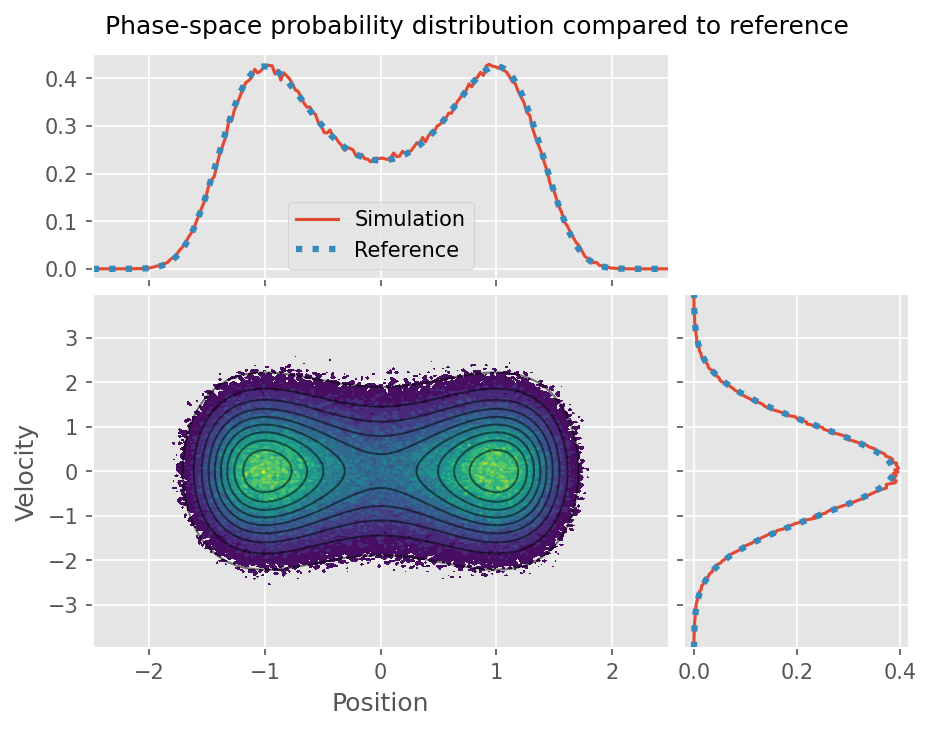

In [39]:
# contours settings
# exclude contour at 0.0
n_levels = 15
levels = np.linspace(0, f.max(), n_levels)[1:]

# layout settings
ratio_axes = 1.5
pad = 0.1

figure, axes = plt.subplots()

# main panel - histogram as filled contours, reference as line contours
# a bit of additional work to make the legend work
contours = plt.contourf(
    f.T,
    origin='lower',
    extent=(*range_q, *range_v),
    cmap='viridis',
    levels=levels
)
contours_ref = plt.contour(
    f_ref.T,
    origin='lower',
    extent=(*range_q, *range_v),
    colors=['black'],
    levels=levels,
    alpha=0.5,
    linewidths=[1.0],
)
plt.xlabel('Position')
plt.ylabel('Velocity')

"""
# custom legend for main panel
# label one of the contours
contours_ref.collections[0].set_label('Reference')
handle_contour = contours_ref.legend_elements()[0][0]
# custom colored patch with a label
color_patch = contours.collections[1].get_facecolor()
handle_patch = mpatches.Patch(color=color_patch, label='Simulation')
# create the legend itself
plt.legend(handles=[handle_patch, handle_contour])"
"""

# custom legend for main panel
# this worked for Matplotlib <3.5
# contours_ref.collections[0].set_label('Reference')
# color_patch = contours.collections[1].get_facecolor()
# proxy = plt.Rectangle((0, 0), 1, 1, fc=color_patch, label='Simulation')
# axes.patches += [proxy]
# plt.legend()

# use a divider to get new axes
divider = make_axes_locatable(axes)
axes_top = divider.append_axes('top', ratio_axes, pad=pad, sharex=axes)
axes_right = divider.append_axes('right', ratio_axes, pad=pad, sharey=axes)

# top marginal
plt.sca(axes_top)
plt.plot(bin_centers_q, f_q, label='Simulation')
plt.plot(bin_centers_q, f_q_ref, ':', lw=3, label='Reference')
plt.tick_params(labelbottom=False)
plt.legend()

# right marginal
plt.sca(axes_right)
plt.plot(f_v, bin_centers_v, label='Simulation')
plt.plot(f_v_ref, bin_centers_v, ':', lw=3, label='Reference')
plt.tick_params(labelleft=False)

# tighten layout
plt.subplots_adjust(left=0.1, bottom=0.1, top=0.925, right=0.95)

plt.suptitle('Phase-space probability distribution compared to reference');

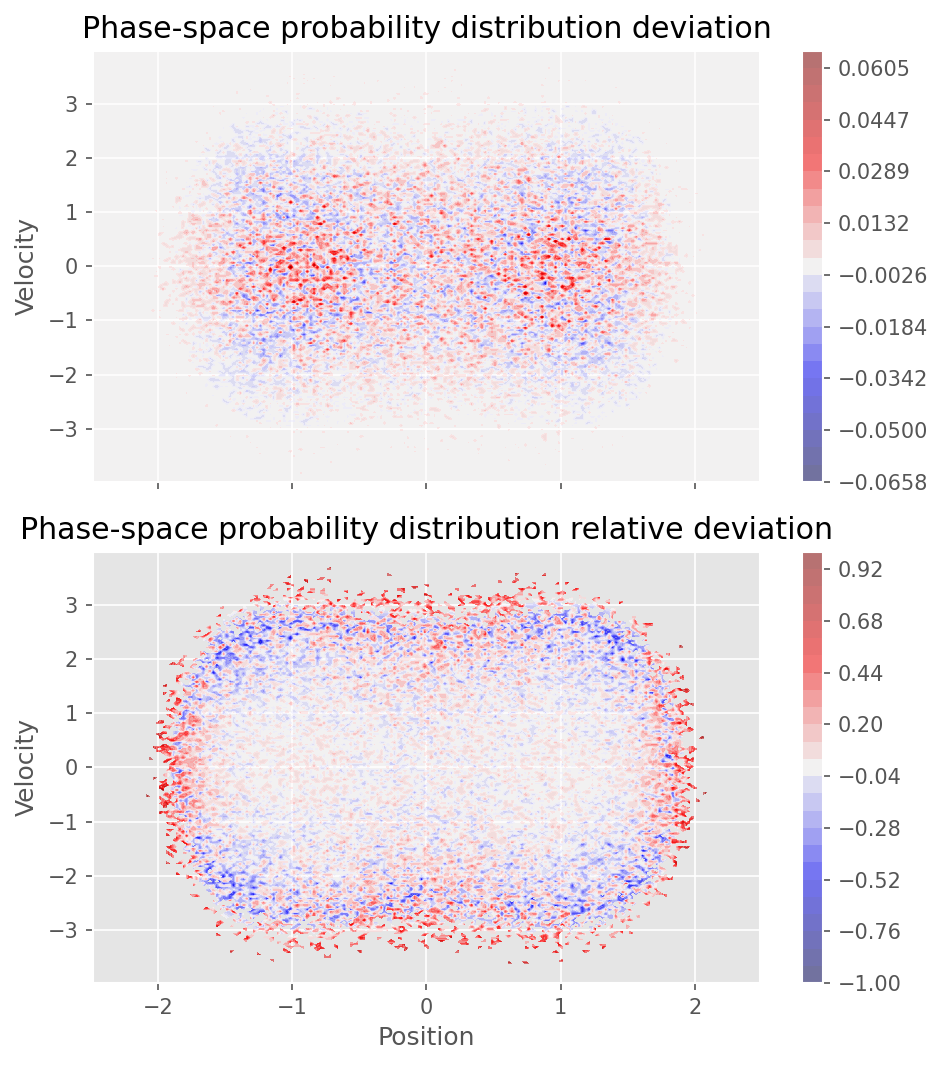

In [40]:
# absolute difference distribution
f_diff = (f - f_ref)
v_amp = np.max([f_diff.max(), np.abs(f_diff.min())])
n_levels_diff = 26
levels_diff = np.linspace(-v_amp, v_amp, n_levels_diff)

# relative difference distribution, avoid division by zero
mask = f > 0
f_diff_rel = np.empty_like(f)
f_diff_rel[:] = np.nan
f_diff_rel[mask] = (f[mask] - f_ref[mask]) / (f[mask] + f_ref[mask])
v_amp_rel = 1.0
levels_diff_rel = np.linspace(-v_amp_rel, v_amp_rel, n_levels_diff)

# change aspect ratio, respect default width
figsize_orig = plt.rcParams['figure.figsize']
figsize = (figsize_orig[0], 1.5 * figsize_orig[1])

plt.subplots(2, 1, figsize=figsize, sharex=True, layout='tight')

plt.subplot(2, 1, 1)
plt.contourf(f_diff.T, origin='lower', extent=(*range_q, *range_v), cmap='seismic', levels=levels_diff, alpha=0.5)
plt.colorbar()
plt.ylabel('Velocity')
plt.title('Phase-space probability distribution deviation')

plt.subplot(2, 1, 2)
plt.contourf(f_diff_rel.T, origin='lower', extent=(*range_q, *range_v), cmap='seismic', levels=levels_diff_rel, alpha=0.5)
plt.colorbar()
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('Phase-space probability distribution relative deviation');